### Import data

In [1]:
import numpy as np
import pandas as pd
import os

# Define directions to folders
data_dir = '/kaggle/input/airbus-ship-detection/'
train_image_dir = os.path.join(data_dir, 'train_v2/')
test_image_dir  = os.path.join(data_dir, 'test_v2/')

# Get the main .csv file
masks = pd.read_csv(os.path.join(data_dir, 'train_ship_segmentations_v2.csv'))
masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


Let's explore the distribution of the number of ships in the image

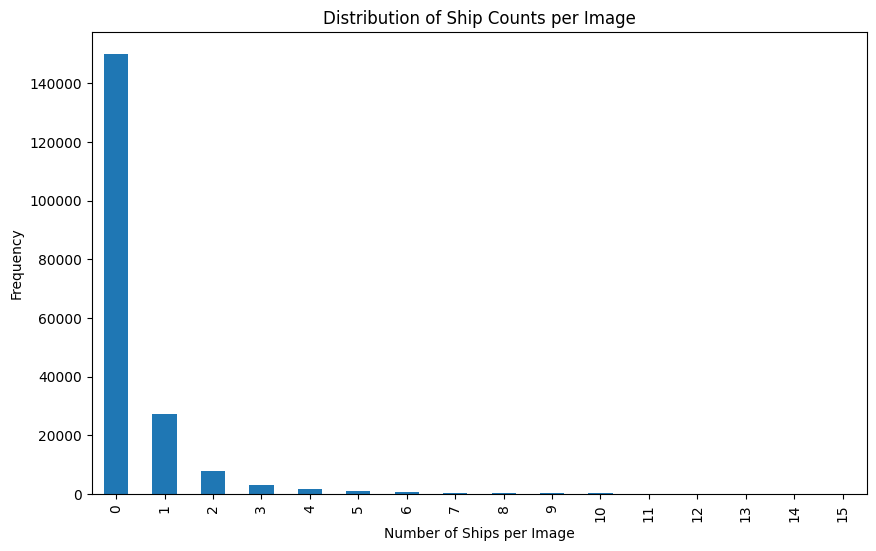

In [2]:
import matplotlib.pyplot as plt

# Group by 'ImageId' and count non-NaN values in 'EncodedPixels' for each ImageId
ship_counts = masks.groupby('ImageId')['EncodedPixels'].apply(lambda x: x.notna().sum())

# Plot the distribution of ship counts
plt.figure(figsize=(10, 6))
ship_counts.value_counts().sort_index().plot(kind='bar')
plt.xlabel('Number of Ships per Image')
plt.ylabel('Frequency')
plt.title('Distribution of Ship Counts per Image')
plt.show()


We can see that there is too many images without any ships.
So I find it usefull to delete all empty images to make the dataset more balanced

In [3]:
# Delete all empty images
masks = masks.dropna(how='any',axis=0)
masks.head()

,ImageId,EncodedPixels
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...


Split the data into train and validation sets

In [4]:
from sklearn.model_selection import train_test_split

# split into train and valid sets + add 'counts' column with number of ships in each image
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.05, 
                 stratify = unique_img_ids['counts'],
                 random_state=42
                )

train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)

print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

77636 training masks
4087 validation masks


### Dataset Loader

In [5]:
from typing import Tuple

def rle_decode(mask_rle: str, shape: Tuple[int, int]=(768, 768)) -> np.ndarray:
    '''
    Converts a list of mask pixels to an image with specified shape.
    
    : param mask_rle: (string) - run-length as string formated (start length).
    : param shape: (tuple) - (height, width) of array to return.
    
    : return: (numpy.ndarray) - resulting image, 1 - mask, 0 - background.
    '''
    s = mask_rle.split()
    if len(s)%2 != 0:
        print(s)
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

Write custom Pytorch Dataset for our data

In [6]:
import os
import cv2
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Normalize, Compose
from typing import Any

class ShipDataset(Dataset):
    '''Class to work with the ship data inherited from Pytorch Dataset.'''
    
    def __init__(self,
                 data: pd.DataFrame,
                 mode: str='train',
                 transform: Any=None) -> None:
        
        '''
        Initializes an instance of ShipDataset.

        : param data: (pandas.DataFrame) - data to work with.
        : param mode: (str) - current mode (only affects file search).
        : param transform: (Any) - transformation that will be applied to images.
        
        : return: (None) - this function does not return any value.
        '''

        # Group EncodedPixels by ImageId
        grouped = data.groupby('ImageId')['EncodedPixels'].apply(lambda x: ' '.join(x))
        self._ids = grouped.index.tolist()
        self._masks = grouped.tolist()
        self._transform = transform
        self._mode = mode
        self._image_transform = Compose([
                ToTensor(),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

    def __len__(self) -> int:
        '''
        Implementation of len() operation.
        
        : return: (int) - number of unique images in the dataset.
        '''
        return len(self._ids)
    
    def __getitem__(self, index: int) -> dict:
        '''
        Implementation of index access.
        
        : param index: (int) - index of element to access.
        
        : return: (dict) - corresponding image and its mask as a dictionary with keys 'image' and 'mask'.
        '''
        
        img_name = self._ids[index]
        
        if self._mode == 'train':
            rgb_path = os.path.join(train_image_dir, img_name)
        else:
            rgb_path = os.path.join(test_image_dir, img_name)
        
        img = self._image_transform(cv2.imread(rgb_path)).permute(1, 2, 0)
        mask = np.expand_dims(rle_decode(self._masks[index]), axis=-1)
        
        sample = {'image': img, 'mask': mask}
        if self._transform:
            sample = self._transform(sample)

        return sample

Let's show any image with its mask to check the correctness of our Dataset

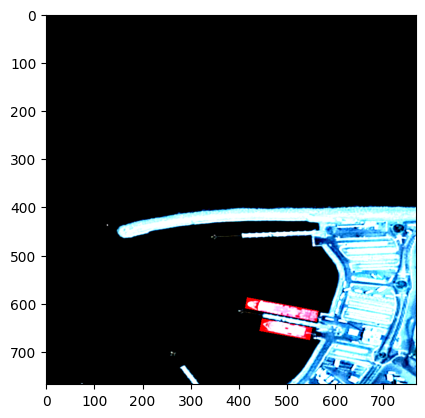

In [7]:
import matplotlib.pyplot as plt

# Function to draw images and their masks
def draw_segments(images: list, segments: list) -> None:
    color = np.array([255,0,0], dtype='uint8')
    for img, seg in zip(images, segments):
        img, seg = np.array(img), np.array(seg)
        masked_img = np.where(seg[...], color, img)
        out = cv2.addWeighted(img, 0.7, masked_img, 0.3, 0)

        plt.imshow(out)
        plt.show()

# Test on some image from valid dataset
dataset_valid = ShipDataset(valid_df)
draw_segments([dataset_valid[10]['image']], [dataset_valid[10]['mask']])

### Data Augmentations

In [8]:
class RandomCrop:
    '''Class for random cropping.'''
    
    def __init__(self, size: Tuple[int, int]) -> None:
        '''
        Initializes an instance of RandomCrop.

        : param size: (Tuple[int, int]) - size of random crop.
        
        : return: (None) - this function does not return any value.
        '''
        self._h = size[0]
        self._w = size[1]

    def __call__(self, sample: dict) -> dict:
        '''
        Selects the random image section with the specified size.

        : param sample: (dict) - dictionary with keys 'image' and 'mask'.
        
        : return: (dict) - returns a sample in the same format after transformation.
        '''
        
        img, mask = sample['image'], sample['mask']
        height, width, _ = img.shape

        h_start = np.random.randint(0, height - self._h)
        w_start = np.random.randint(0, width - self._w)

        img = img[h_start: h_start + self._h, w_start: w_start + self._w,:]

        assert img.shape[0] == self._h
        assert img.shape[1] == self._w

        if mask is not None:
            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=2)
            mask = mask[h_start: h_start + self._h, w_start: w_start + self._w,:]

        return {'image': img, 'mask': mask}

class RandomFlip:
    '''Class for random flip.'''
    
    def __init__(self, prob: float=0.5) -> None:
        '''
        Initializes an instance of RandomFlip.

        : param prob: (float) - probability of flipping an image along some axis.
        
        : return: (None) - this function does not return any value.
        '''
        self._prob = prob

    def __call__(self, sample: dict) -> dict:
        '''
        Flips the image along x, y or both axes with specified probability.

        : param sample: (dict) - dictionary with keys 'image' and 'mask'.
        
        : return: (dict) - returns a sample in the same format after transformation.
        '''
        
        img, mask = sample['image'], sample['mask']
        if random.random() < self._prob:
            d = random.randint(-1, 1)
            img = cv2.flip(np.array(img), d)
            if mask is not None:
                mask = cv2.flip(np.array(mask), d)
                if mask.ndim == 2:
                    mask = np.expand_dims(mask, axis=2)
        return {'image': torch.Tensor(img), 'mask': mask}

class RandomBrightness:
    '''Class for random brightness.'''
    
    def __init__(self, limit: float=0.1, prob: float=0.5) -> None:
        '''
        Initializes an instance of RandomBrightness.
        
        : param limit: (float) - value which limits the range of random brightness.
        : param prob: (float) - probability of changing image brightness.
        
        : return: (None) - this function does not return any value.
        '''
        self._limit = limit
        self._prob = prob

    def __call__(self, sample: dict) -> dict:
        '''
        Randomly changes the brightness of the image with the given parameters.

        : param sample: (dict) - dictionary with keys 'image' and 'mask'.
        
        : return: (dict) - returns a sample in the same format after transformation.
        '''
        
        img, mask = sample['image'], sample['mask']
        if random.random() < self._prob:
            alpha = 1.0 + self._limit * random.uniform(-1, 1)
            img = np.array(img)
            maxval = np.max(img[..., :3])
            dtype = img.dtype
            img[..., :3] = np.clip(alpha * img[..., :3], 0, maxval).astype(dtype)
        
        return {'image': torch.Tensor(img), 'mask': mask}


class RandomContrast:
    '''Class for random contrast.'''
    
    def __init__(self, limit: float=0.1, prob: float=0.5) -> None:
        '''
        Initializes an instance of RandomContrast.
        
        : param limit: (float) - value which limits the range of random contrast.
        : param prob: (float) - probability of changing image contrast.
        
        : return: (None) - this function does not return any value.
        '''
        self._limit = limit
        self._prob = prob

    def __call__(self, sample: dict) -> dict:
        '''
        Randomly changes the contrast of the image with the given parameters.

        : param sample: (dict) - dictionary with keys 'image' and 'mask'.
        
        : return: (dict) - returns a sample in the same format after transformation.
        '''
        
        img, mask = sample['image'], sample['mask']
        if random.random() < self._prob:
            alpha = 1.0 + self._limit * random.uniform(-1, 1)
            img = np.array(img)
            gray = cv2.cvtColor(img[:, :, :3], cv2.COLOR_BGR2GRAY)
            gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
            maxval = np.max(img[..., :3])
            dtype = img.dtype
            img[:, :, :3] = np.clip(alpha * img[:, :, :3] + gray, 0, maxval).astype(dtype)
        
        return {'image': torch.Tensor(img), 'mask': mask}


List augmentations for train and validation

In [9]:
# train transformation
train_transform = Compose([RandomCrop((256, 256)),
                           RandomFlip(),
                           RandomBrightness()])

# valid transformation
val_transform = Compose([
        RandomCrop((512, 512)),
      ])

Show an example of augmentations applied

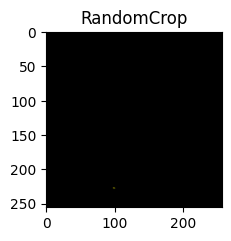

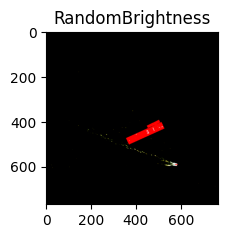

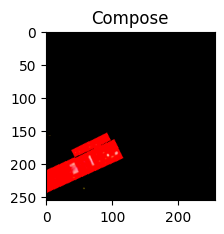

In [10]:
import random
from torchvision import transforms

# Augmentations to test.
crop = RandomCrop((256, 256))
flip = RandomBrightness()
composed = transforms.Compose([crop,
                               flip])

# Apply each of the above transforms on sample.
fig = plt.figure()
dataset_valid = ShipDataset(valid_df)
sample = dataset_valid[6]
for i, tsfrm in enumerate([crop, flip, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    draw_segments([transformed_sample['image']], [transformed_sample['mask']])

plt.show()

### U-Net Segmentation Model

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class UNet_down_block(torch.nn.Module):
    '''Class for the UNet downsample block.'''
    
    def __init__(self, input_channel, output_channel, down_size):
        super(UNet_down_block, self).__init__()
        self.conv1 = torch.nn.Conv2d(input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.max_pool = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()
        self.down_size = down_size

    def forward(self, x):
        if self.down_size:
            x = self.max_pool(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x

class UNet_up_block(torch.nn.Module):
    '''Class for the UNet upsample block.'''
    
    def __init__(self, prev_channel, input_channel, output_channel):
        super(UNet_up_block, self).__init__()
        self.up_sampling = torch.nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv1 = torch.nn.Conv2d(prev_channel + input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.relu = torch.nn.ReLU()

    def forward(self, prev_feature_map, x):
        x = self.up_sampling(x)
        x = torch.cat((x, prev_feature_map), dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x


class UNet(torch.nn.Module):
    '''Main class for the UNet model.'''
    
    def __init__(self):
        super(UNet, self).__init__()

        self.down_block1 = UNet_down_block(3, 16, False)
        self.down_block2 = UNet_down_block(16, 32, True)
        self.down_block3 = UNet_down_block(32, 64, True)
        self.down_block4 = UNet_down_block(64, 128, True)
        self.down_block5 = UNet_down_block(128, 256, True)
        self.down_block6 = UNet_down_block(256, 512, True)
        self.down_block7 = UNet_down_block(512, 1024, True)

        self.mid_conv1 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(1024)
        self.mid_conv2 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(1024)
        self.mid_conv3 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(1024)

        self.up_block1 = UNet_up_block(512, 1024, 512)
        self.up_block2 = UNet_up_block(256, 512, 256)
        self.up_block3 = UNet_up_block(128, 256, 128)
        self.up_block4 = UNet_up_block(64, 128, 64)
        self.up_block5 = UNet_up_block(32, 64, 32)
        self.up_block6 = UNet_up_block(16, 32, 16)

        self.last_conv1 = torch.nn.Conv2d(16, 16, 3, padding=1)
        self.last_bn = torch.nn.BatchNorm2d(16)
        self.last_conv2 = torch.nn.Conv2d(16, 1, 1, padding=0)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        self.x1 = self.down_block1(x)
        self.x2 = self.down_block2(self.x1)
        self.x3 = self.down_block3(self.x2)
        self.x4 = self.down_block4(self.x3)
        self.x5 = self.down_block5(self.x4)
        self.x6 = self.down_block6(self.x5)
        self.x7 = self.down_block7(self.x6)
        self.x7 = self.relu(self.bn1(self.mid_conv1(self.x7)))
        self.x7 = self.relu(self.bn2(self.mid_conv2(self.x7)))
        self.x7 = self.relu(self.bn3(self.mid_conv3(self.x7)))
        x = self.up_block1(self.x6, self.x7)
        x = self.up_block2(self.x5, x)
        x = self.up_block3(self.x4, x)
        x = self.up_block4(self.x3, x)
        x = self.up_block5(self.x2, x)
        x = self.up_block6(self.x1, x)
        x = self.relu(self.last_bn(self.last_conv1(x)))
        x = self.last_conv2(x)
        return x

### Loss Function

In [12]:
class LossBinary:
    '''Class for the Binary Loss. Here is the implementation of loss function
    using combination of BCELoss - Jaccard Index.'''
    
    def __init__(self, jaccard_weight=0):
        self.nll_loss = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight

    def __call__(self, outputs, targets):
        targets = targets.float()
        loss = self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            eps = 1e-15
            jaccard_target = (targets == 1.0).float()
            jaccard_output = F.sigmoid(outputs)

            intersection = (jaccard_output * jaccard_target).sum()
            union = jaccard_output.sum() + jaccard_target.sum()

            loss -= self.jaccard_weight * torch.log((intersection + eps) / (union - intersection + eps))
        
        return loss

In [13]:
class LossBinaryF2:
    """
    Jaccard Index + Soft F2 Loss for segmentation tasks.
    """

    def __init__(self, jaccard_weight=0, f2_weight=1):
        self.jaccard_weight = jaccard_weight
        self.f2_weight = f2_weight

    def soft_f2(self, outputs, targets, beta=2, eps=1e-7):
        """
        Computes the Soft F2 Score for differentiable approximation.
        """
        outputs = torch.sigmoid(outputs)  # Convert logits to probabilities
        targets = targets.float()

        tp = (outputs * targets).sum()        # True Positives
        fp = ((1 - targets) * outputs).sum()  # False Positives
        fn = (targets * (1 - outputs)).sum()  # False Negatives

        # Soft F2 Score calculation
        f2_score = (1 + beta**2) * tp / ((1 + beta**2) * tp + beta**2 * fn + fp + eps)
        soft_f2_loss = 1 - f2_score  # Loss is 1 - Soft F2 Score
        return soft_f2_loss

    def jaccard_index(self, outputs, targets, eps=1e-7):
        """
        Computes the Jaccard Index (IoU).
        """
        outputs = torch.sigmoid(outputs)  # Convert logits to probabilities
        targets = targets.float()

        intersection = (outputs * targets).sum()
        union = outputs.sum() + targets.sum() - intersection
        jaccard = (intersection + eps) / (union + eps)
        jaccard_loss = -torch.log(jaccard)
        return jaccard_loss

    def __call__(self, outputs, targets):
        # Compute Soft F2 Loss
        loss = self.f2_weight * self.soft_f2(outputs, targets)
        
        # Compute Jaccard Loss if jaccard_weight > 0
        if self.jaccard_weight:
            jaccard_loss = self.jaccard_weight * self.jaccard_index(outputs, targets)
            loss += jaccard_loss
            
        return loss


Validation and some helper functions

In [14]:
def to_device(x: torch.Tensor) -> torch.Tensor:
    '''
    Performs device conversion based on cuda availability.
    
    : param x: (torch.Tensor) - initial tensor.
        
    : return:  (torch.Tensor) - the tensor after device conversion.
    '''
    return x.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

def get_jaccard(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    '''
    Implementation of Jaccard Index. Used during validation.
    
    : param y_true: (torch.Tensor) - ground truth mask.
    : param y_pred: (torch.Tensor) - predicted mask.
    
    : return: (float) - Jaccard Index value.
    '''
    epsilon = 1e-15
    intersection = (y_pred * y_true).sum(dim=-2).sum(dim=-1).sum(dim = -1)
    union = y_true.sum(dim=-2).sum(dim=-1).sum(dim=-1) + y_pred.sum(dim=-2).sum(dim=-1).sum(dim = -1)

    return (intersection / (union - intersection + epsilon)).mean()

def validation(model: nn.Module, criterion, valid_loader):
    '''Performs validation.'''
    
    print("Validation on hold-out....")
    model.eval()
    losses = []
    jaccard = []
    with torch.no_grad():
        for sample in valid_loader:
            inputs = sample['image']
            targets = sample['mask']
            inputs = torch.moveaxis(inputs, 3, 1)
            targets = torch.moveaxis(targets, 3, 1)
            inputs  = to_device(inputs)
            targets = to_device(targets)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            losses.append(loss.cpu().data)
            jaccard += [get_jaccard(targets.float(), (outputs > 0).float()).cpu().data]

        valid_loss = np.mean(losses)  # type: float
        valid_jaccard = np.mean(jaccard)

    print('Valid loss: {:.5f}, jaccard: {:.5f}'.format(valid_loss, valid_jaccard))
    metrics = {'valid_loss': valid_loss, 'jaccard_loss': valid_jaccard}
    return metrics

In [15]:
import json
from datetime import datetime
import logging

# Configure logging to only show critical errors in the console
logging.basicConfig(level=logging.CRITICAL)

def write_event(log, step: int, show_console: bool=False, **data) -> None:
    '''Helper function to write train stages to the log file.'''
    
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log_entry = json.dumps(str(data), sort_keys=True)
    
    # Write to log file
    log.write(log_entry + '\n')
    log.flush()
    
    # Optionally print to console
    if show_console:
        print(log_entry)


### Train the model

In [16]:
from tqdm import tqdm
from pathlib import Path
import random

def train(lr, model, criterion, train_loader, valid_loader, validation, init_optimizer, n_epochs=1, fold=1):
    '''Performs model training process.'''
    
    optimizer = init_optimizer(lr)
    if torch.cuda.is_available():
        model.cuda()
       
    model_path = Path('model_{fold}.pt'.format(fold=fold))
    if model_path.exists():
        state = torch.load(str(model_path))
        epoch = state['epoch']
        step = state['step']
        model.load_state_dict(state['model'])
        print('Restored model, epoch {}, step {:,}'.format(epoch, step))
    else:
        epoch = 1
        step = 0

    save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))


    report_each = 50
    log = open('train_{fold}.log'.format(fold=fold),'at', encoding='utf8')
    valid_losses = []
    for epoch in range(epoch, n_epochs + 1):
        model.train()
        random.seed()
        tq = tqdm(total=len(train_loader) *  BATCH_SIZE)
        tq.set_description('Epoch {}, lr {}'.format(epoch, lr))
        losses = []
        tl = train_loader
        try:
            mean_loss = 0
            for i, sample in enumerate(tl):
                inputs = sample['image']
                targets = sample['mask']
                inputs, targets = to_device(inputs), to_device(targets)
                inputs = torch.moveaxis(inputs, 3, 1)
                targets = torch.moveaxis(targets, 3, 1)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                optimizer.zero_grad()
                batch_size = inputs.size(0)
                loss.backward()
                optimizer.step()
                step += 1
                tq.update(batch_size)
                losses.append(loss.cpu().data)
                mean_loss = np.mean(losses[-report_each:])
                tq.set_postfix(loss='{:.5f}'.format(mean_loss))
                if i and i % report_each == 0:
                    write_event(log, step, loss=mean_loss)
            write_event(log, step, show_console=True, loss=mean_loss)
            tq.close()
            save(epoch + 1)
            valid_metrics = validation(model, criterion, valid_loader)
            write_event(log, step, show_console=True, **valid_metrics)
            valid_loss = valid_metrics['valid_loss']
            valid_losses.append(valid_loss)
        except KeyboardInterrupt:
            tq.close()
            print('Ctrl+C, saving snapshot')
            save(epoch)
            print('done.')
            return

In [17]:
BATCH_SIZE = 16

def make_loader(in_df, batch_size, shuffle=False, transform=None):
    '''Returns dataloader with specified parameters using ShipDataset.'''
    
    return DataLoader(
        dataset=ShipDataset(in_df, transform=transform),
        shuffle=shuffle,
        num_workers = 0,
        batch_size = batch_size,
        pin_memory=torch.cuda.is_available()
    )

# Train and validation dataloaders
train_loader = make_loader(train_df, batch_size = BATCH_SIZE, shuffle=True, transform=train_transform)
valid_loader = make_loader(valid_df, batch_size = BATCH_SIZE // 2, transform=None)

In [18]:
# run just 3 epochs
model = UNet()
train(init_optimizer=lambda lr: torch.optim.Adam(model.parameters(), lr=lr),
        lr = 1e-4,
        n_epochs = 3,
        model=model,
        criterion=LossBinaryF2(jaccard_weight=1),
        train_loader=train_loader,
        valid_loader=valid_loader,
        validation=validation,
        )

Epoch 1, lr 0.0001: 100%|█████████▉| 40428/40432 [43:28<00:00, 15.50it/s, loss=5.63419]


"{'loss': 5.634188, 'step': 2527, 'dt': '2024-10-28T17:18:08.427697'}"
Validation on hold-out....
Valid loss: 4.37116, jaccard: 0.25458
"{'valid_loss': 4.371159, 'jaccard_loss': 0.2545787, 'step': 2527, 'dt': '2024-10-28T17:20:10.398520'}"


Epoch 2, lr 0.0001: 100%|█████████▉| 40428/40432 [34:29<00:00, 19.53it/s, loss=2.94427]


"{'loss': 2.9442666, 'step': 5054, 'dt': '2024-10-28T17:54:39.939370'}"
Validation on hold-out....
Valid loss: 2.48297, jaccard: 0.29067
"{'valid_loss': 2.4829655, 'jaccard_loss': 0.29066756, 'step': 5054, 'dt': '2024-10-28T17:56:23.944458'}"


Epoch 3, lr 0.0001: 100%|█████████▉| 40428/40432 [35:13<00:00, 19.13it/s, loss=2.69227]


"{'loss': 2.692269, 'step': 7581, 'dt': '2024-10-28T18:31:36.989815'}"
Validation on hold-out....
Valid loss: 1.58614, jaccard: 0.33309
"{'valid_loss': 1.5861436, 'jaccard_loss': 0.33309472, 'step': 7581, 'dt': '2024-10-28T18:33:13.442020'}"


### Analysis and predictions

Let's plot train and validation losses to explore the training process

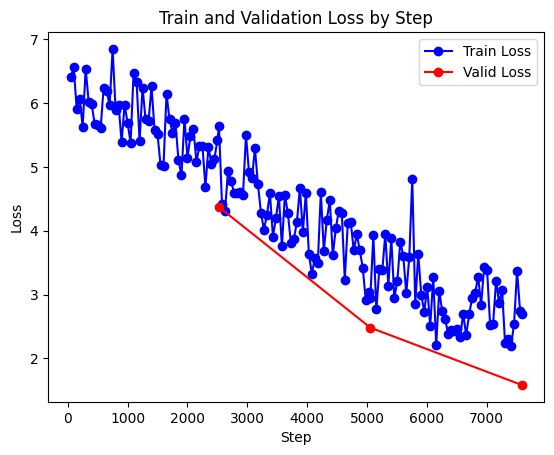

In [19]:
import ast

log_file = '/kaggle/working/train_1.log'
logs = pd.read_json(log_file, lines=True)

# Convert the string representation of dictionaries to actual dictionaries
logs['parsed'] = logs.iloc[:, 0].apply(ast.literal_eval)

# Extract loss and step into separate columns by applying a lambda function to each element in 'parsed'
logs['train_loss'] = logs['parsed'].apply(lambda x: x.get('loss'))
logs['valid_loss'] = logs['parsed'].apply(lambda x: x.get('valid_loss'))
logs['step'] = logs['parsed'].apply(lambda x: x.get('step'))

# Drop NaN values individually for each loss type
train_loss_df = logs.dropna(subset=['train_loss'])
valid_loss_df = logs.dropna(subset=['valid_loss'])

# Plotting
plt.plot(train_loss_df['step'], train_loss_df['train_loss'], marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(valid_loss_df['step'], valid_loss_df['valid_loss'], marker='o', linestyle='-', color='r', label='Valid Loss')

# Labels and title
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Train and Validation Loss by Step')
plt.legend()
plt.show()

Load our trained model weights

In [20]:
model = UNet()
model.load_state_dict(torch.load('/kaggle/working/model_1.pt', weights_only=True)['model'])
model.eval()

UNet(
  (down_block1): UNet_down_block(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (down_block2): UNet_down_block(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, af

Look at some model predictions on validation set

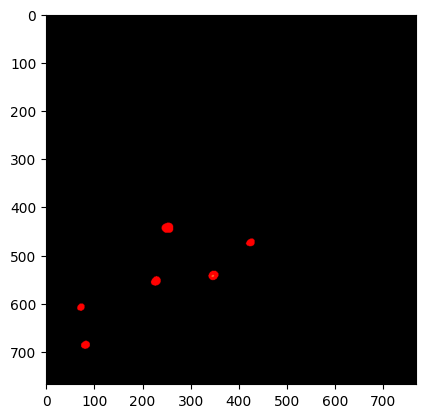

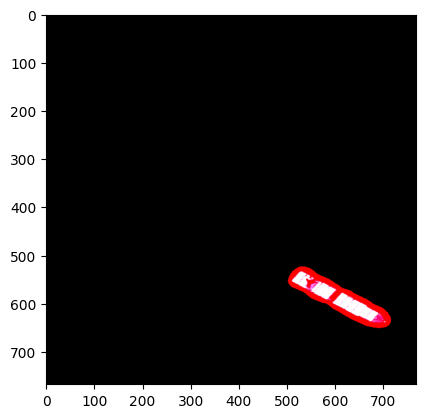

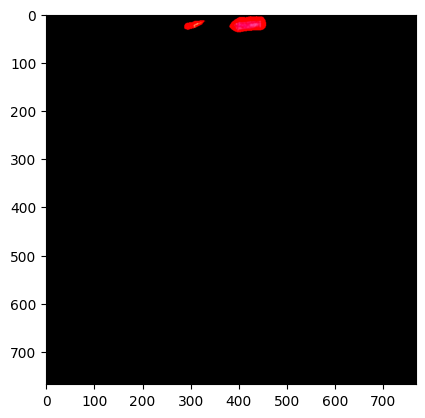

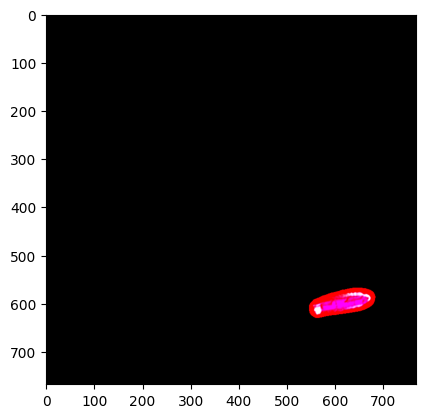

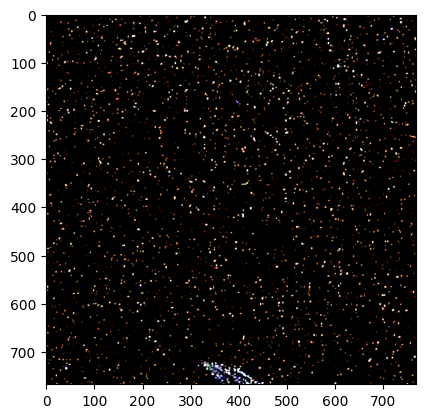

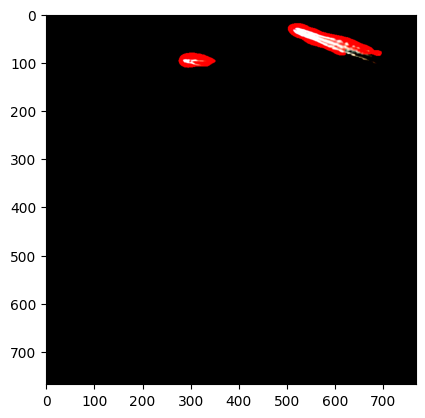

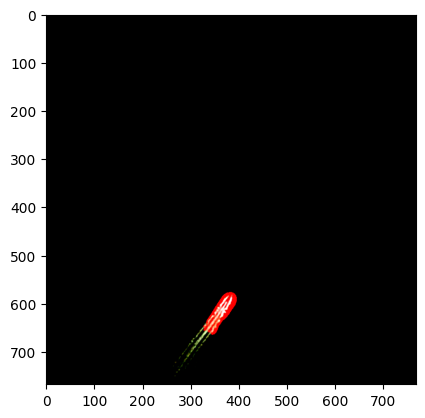

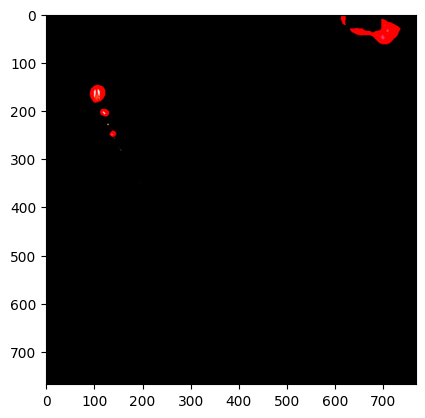

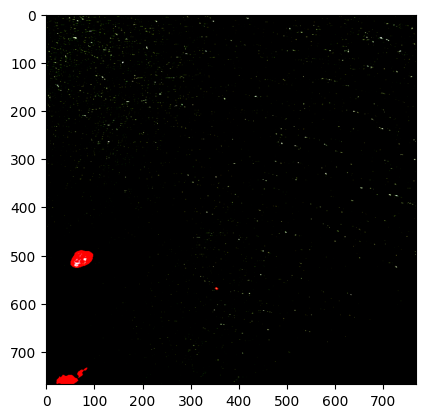

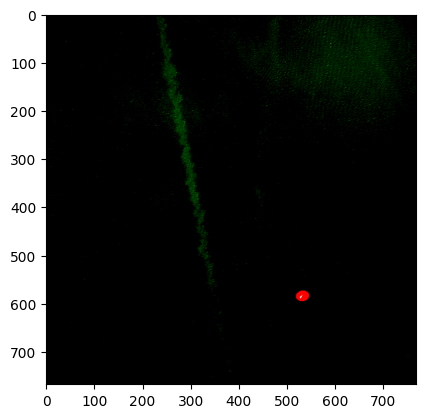

In [21]:
from torch.nn import functional as F
import random

threshold = 0.5
images_to_draw = []
masks_to_draw  = []
valid_ds = ShipDataset(valid_df)

for i in range(10):
    sample = valid_ds[random.randrange(0, len(valid_ds))]
    with torch.no_grad():
        input_img = torch.moveaxis(torch.unsqueeze(sample['image'], dim=0), 3, 1)
        mask = F.sigmoid(model(input_img))
        out_mask = torch.moveaxis(torch.squeeze(mask.data.cpu(), dim = 0), 0, 2)
        input_img = torch.moveaxis(torch.squeeze(input_img), 0, 2)
        out_mask = np.where(out_mask > threshold, 1, 0)
        images_to_draw.append(input_img)
        masks_to_draw.append(out_mask)

draw_segments(images_to_draw, masks_to_draw)